# Global News Engagement on Social Media

Taken from [Kaggle](https://www.kaggle.com/datasets/kanchana1990/global-news-engagement-on-social-media).

## Objective

Find out if the topics of articles have anything to do with social media engagement by first performing clustering, and then fitting classifier models.

# Import Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import nltk
import seaborn as sns
import time
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from wordcloud import WordCloud, STOPWORDS 

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

dir = 'data'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Quartz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Quartz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Quartz\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Load Dataset

In [28]:
df = pd.DataFrame()
dfs = []
for ff in os.listdir(dir):
    file_path = os.path.join(dir, ff)
    df_load = pd.read_csv(file_path)
    df_load['source'] = ff.replace('.csv', '')
    dfs.append(df_load)
df = pd.concat(dfs, join='inner')
df.head(3)

,text,likes,comments,shares,source
0,“Numbers dropped by around half after the eart...,303,15,5,al_jazeera
1,This exclusive footage obtained by Al Jazeera ...,809,174,81,al_jazeera
2,The disappearance of 6-year-old Joshlin Smith ...,236,75,33,al_jazeera


# Drop nulls

In [29]:
df.dropna(how='any', inplace=True)

# Text Preprocessing

We transform each string to lowercase, remove special characters, and apply lemmatization.

In [30]:
def clean_str(x):
    """
    Return cleaned string
    """
    x = x.lower()
    x = re.sub(r'[^a-zA-Z0-9]', ' ', x)
    tokens = word_tokenize(x)
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized)

df['text'] = df['text'].apply(lambda x: clean_str(x))
df.head(3)

,text,likes,comments,shares,source
0,number dropped by around half after the earthq...,303,15,5,al_jazeera
1,this exclusive footage obtained by al jazeera ...,809,174,81,al_jazeera
2,the disappearance of 6 year old joshlin smith ...,236,75,33,al_jazeera


# Exploratory Data Analysis

Let us analyze the relationships between the three metrics of engagement: likes, comments, and shares.

## Pairplot

Note that they all have a "fan-out" relationship. Meaning, the articles tend to pool in a certain engagement range.

There are some exemplary articles that have high metrics across the board, but these look to be few. We can identify these articles as "viral".

Additionally, note that **reuters** articles tend to lag in terms of social media engagement. Why is that so? Let's explore further.

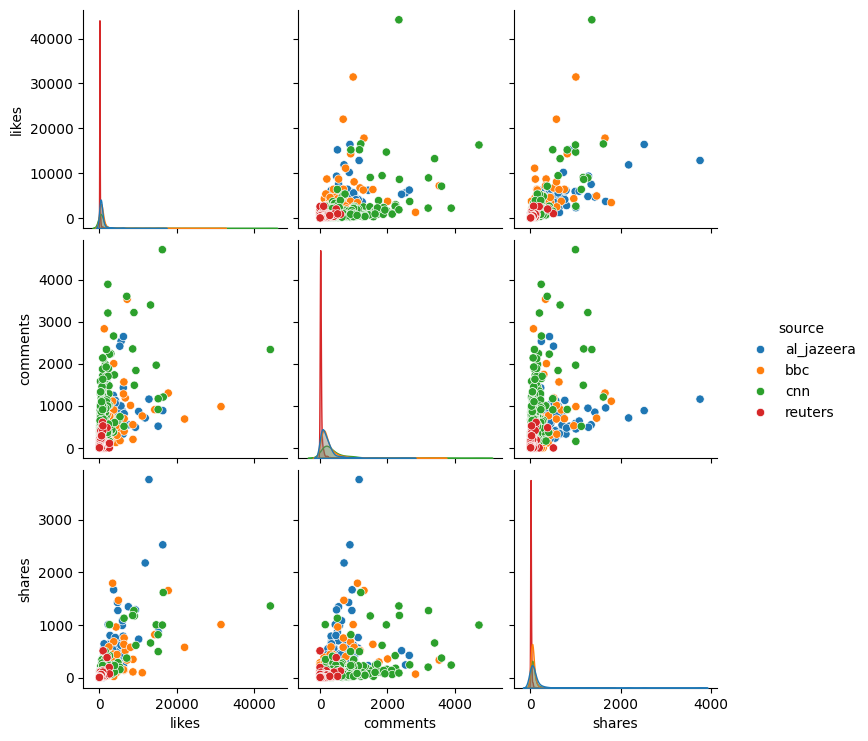

In [31]:
sns.pairplot(df, hue='source')
plt.show()

## Heatmap

The three metrics in general are positively correlated with each other, however likes and shares standout as having very high positive correlation. This means that high shares likely point to high likes. Comments have a relatively lukewarm correlation with likes and shares, but the relationship is positive nonetheless.

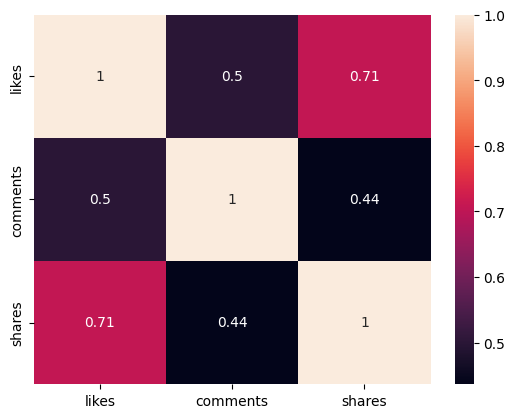

In [32]:
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()

## Define engagement ranges

Here we establish metrics for how we classify articles. How do we know that an article is viral? Conversely, how do we know that an article is underperfoming in terms of engagement? We will look to the histograms of metrics to establish ranges.

Based on the histograms below, it seems that majority of the articles fall in certain ranges, save for highly viral articles that are outliers, as you will see in the `max_value`.

Hence, we will establish the following rules:

1. An **underperforming** article's metrics fall below the 25th percentile of any of the metrics.
2. An **average** article's metrics fall in the 25th-90th percentile of metrics.
3. A **viral** article should have all their metrics beyond the 90th percentile.
4. If an article does not fall squarely in any of the above categories, they will be tagged as **mixed**

In [33]:
def create_histogram_for_metric(df, metric):
    """
    Plot histogram for the chosen metric
    """
    per_dict = {}
    plt.figure(figsize=(12, 6))
    plt.hist(df[metric], color='skyblue', edgecolor='black')
    percentiles = [25, 80, 90]
    quantiles = np.percentile(df[metric], percentiles)
    max_value = max(df[metric])
    for percentile, quantile in zip(percentiles, quantiles):
        print(f"{percentile}th percentile: {quantile}")
        plt.axvline(x=quantile, color='red', linestyle='--')
        per_dict[percentile] = quantile
    print(f"max value: {max_value}")
    plt.xlim(0, max_value)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {metric}')
    plt.show()
    
    per_dict['max_value'] = max_value
    
    per_dict["underperforming"] = range(0, int(per_dict[25]))
    per_dict["average"] = range(int(per_dict[25]+1), int(per_dict[90]))
    per_dict["viral"] = range(int(per_dict[90]+1), int(max_value))
    return percentiles, per_dict

25th percentile: 127.0
80th percentile: 624.4000000000001
90th percentile: 1017.0
max value: 44198


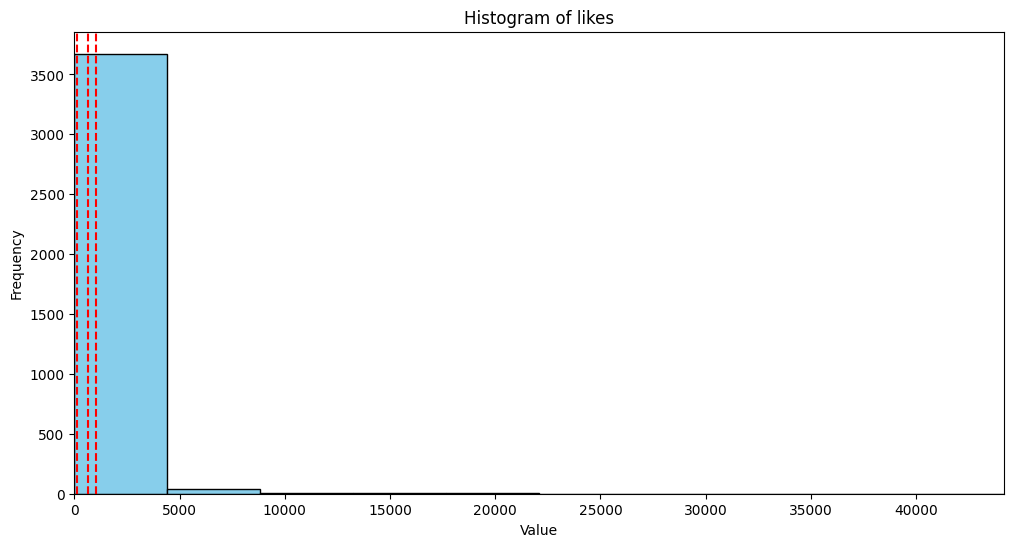

25th percentile: 12.0
80th percentile: 73.0
90th percentile: 121.70000000000027
max value: 3758


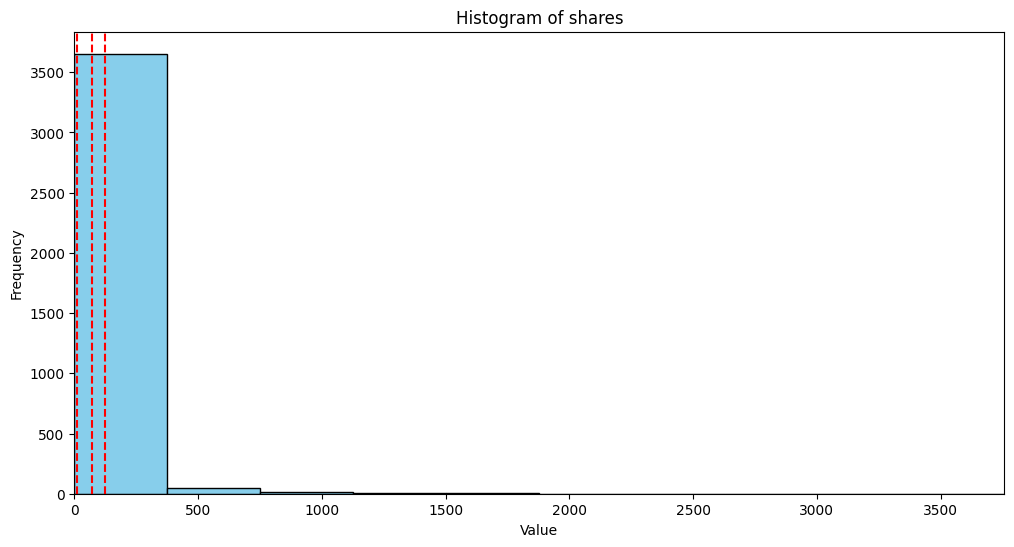

25th percentile: 23.25
80th percentile: 301.4000000000001
90th percentile: 514.0
max value: 4713


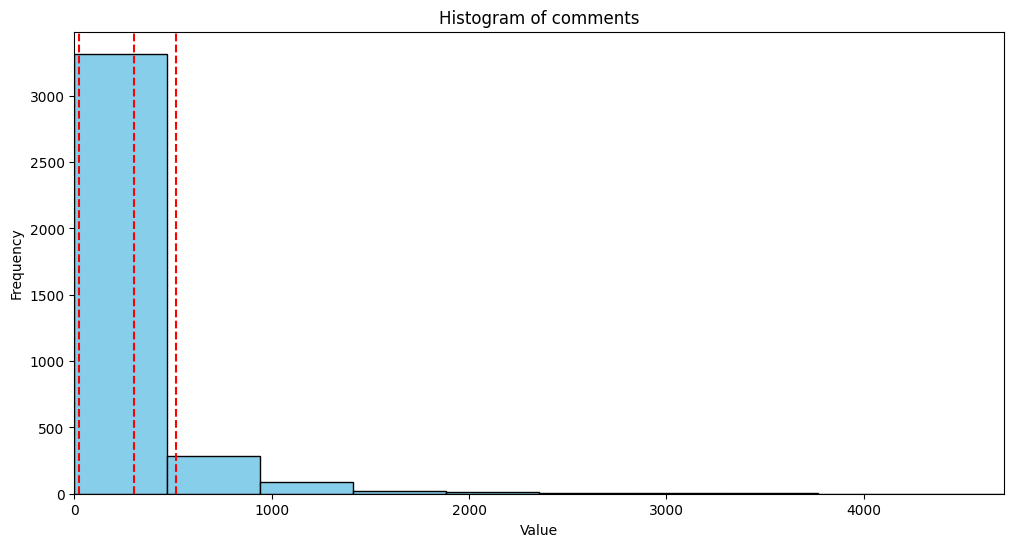

In [34]:
metrics = ['likes', 'shares', 'comments']
metrics_ranges= {}
for m in metrics:
    _, metrics_ranges[m] = create_histogram_for_metric(df, m)

## Label each article according to the established metrics

Next, we label each article according to the established metrics. Again, if an article does not hit any of the aforementioned criteria, they will be labelled "mixed".

In [35]:
labels = []
for ind, row in df.iterrows():
    if (row["likes"] in metrics_ranges["likes"]["underperforming"]
        and row["comments"] in metrics_ranges["comments"]["underperforming"]
        and row["shares"] in metrics_ranges["shares"]["underperforming"]):
        labels.append("underperforming")
    elif (row["likes"] in metrics_ranges["likes"]["average"]
        and row["comments"] in metrics_ranges["comments"]["average"]
        and row["shares"] in metrics_ranges["shares"]["average"]):
        labels.append("average")
    elif (row["likes"] in metrics_ranges["likes"]["viral"]
        and row["comments"] in metrics_ranges["comments"]["viral"]
        and row["shares"] in metrics_ranges["shares"]["viral"]):
        labels.append("viral")
    else:
        labels.append("mixed")

In [36]:
df["label"] = labels
df

,text,likes,comments,shares,source,label
0,number dropped by around half after the earthq...,303,15,5,al_jazeera,mixed
1,this exclusive footage obtained by al jazeera ...,809,174,81,al_jazeera,average
2,the disappearance of 6 year old joshlin smith ...,236,75,33,al_jazeera,average
3,million are still suffering the pandemic s lin...,87,11,11,al_jazeera,underperforming
4,multan sultan face peshawar zalmi in the pakis...,522,71,5,al_jazeera,mixed
...,...,...,...,...,...,...
995,china s top legislator vowed to enact a slew o...,31,1,7,reuters,underperforming
996,a the u congress struggle to pas legislation t...,78,46,7,reuters,mixed
997,president joe biden s state of the union addre...,49,37,4,reuters,mixed
998,australia s great barrier reef ha been hit by ...,54,4,10,reuters,underperforming


## Check the composition of article performance

* There are 1863 average performance articles
* There are 1060 mixed performance articles
* There are 687 underperforming articles
* There are 124 viral articles

In [37]:
val_counts = df["label"].value_counts()
val_counts

label
average            1863
mixed              1060
underperforming     687
viral               124
Name: count, dtype: int64

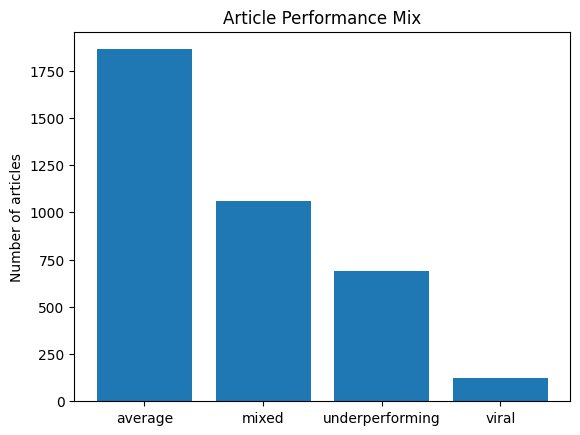

In [38]:
plt.bar(val_counts.index, val_counts)
plt.title("Article Performance Mix")
plt.ylabel("Number of articles")
plt.show()

# What makes a "viral" / "underperforming" article?

Let us perform clustering to understand what kind of articles drive social media engagement, and what kind of articles perform badly.

## Wordcloud

Let's take a look at the most frequently occurring words in the corpus.

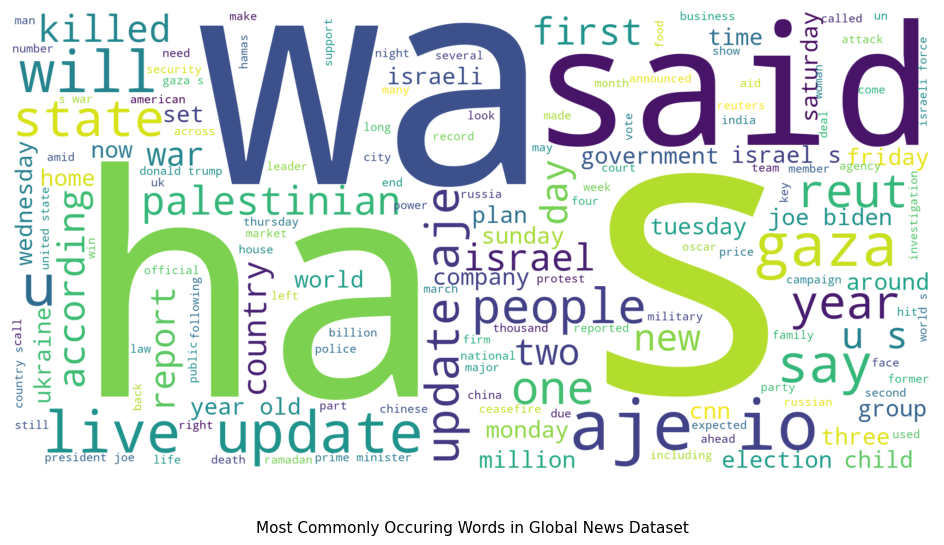

In [39]:
# Create subplots
plt.figure(figsize=(15, 6))

# Subplot 1
all_words = " ".join(df["text"])
wc = WordCloud(background_color='white', stopwords=set(STOPWORDS),scale=5, min_font_size=5).generate(all_words)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Commonly Occuring Words in Global News Dataset', fontsize=11, y=-0.15)
caption = 'The larger words represent the higher frequency occuring words in the corpus'

Based on the wordcloud, we can see that most commonly occuring tokens are related to politics, international events, and war. This makes sense, as these news providers' main focus is providing news coverage on these topics. However, that still does not answer our question.

## TF-IDF

We apply TF-IDF to extract pertinent features of each article. We only take words that have at least 3 characters. Additionally, we only take tokens that appear in at least 1% of the articles and at most 95% of the articles.

In [40]:
# construct TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(
    token_pattern=r'[a-z\']{3,}',
    stop_words='english',
    min_df=0.01,
    max_df=0.95
)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["text"])
feature_names = tfidf_vectorizer.get_feature_names_out()
nonzeros = tfidf_matrix.sum(axis=1).nonzero()[0]
tfidf_matrix1 = tfidf_matrix[nonzeros]
df_text = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [41]:
df_text

,according,address,agency,ahead,aid,air,aje,american,amid,announced,...,voter,war,wednesday,week,west,win,woman,won,world,year
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.412676,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.331483
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.332615,0.000000
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3730,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.490204
3731,0.0,0.287608,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.211838,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3732,0.0,0.000000,0.462539,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


## Apply Truncated SVD

Reduce dimensions using Truncated SVD.

In [42]:
U, S, V = np.linalg.svd(df_text, full_matrices=False)
reconstructed_matrix1 = U @ np.diag(S) @ V
assert np.allclose(reconstructed_matrix1, df_text.to_numpy()) is True
feature_names = df_text.columns.tolist()

## Plot Variance Explained

Here we see that after applying Truncated SVD and reducing dimensions, we retain 165 SVs to explain 90% of the variance.

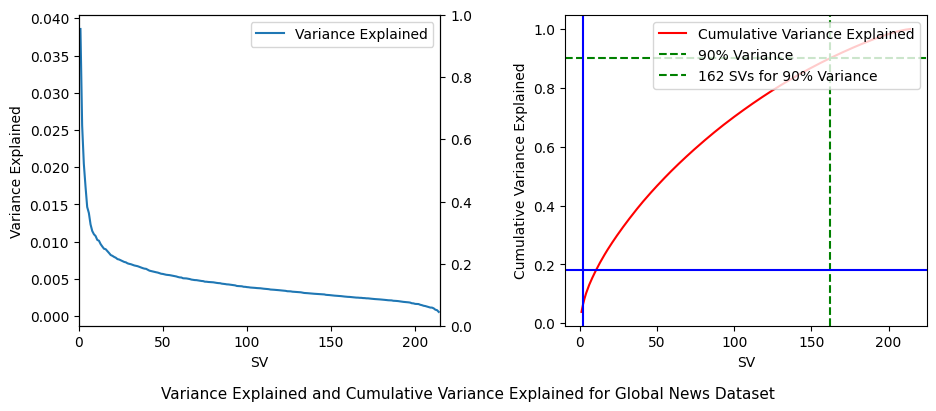

In [43]:
var_explained1 = np.square(S) / np.sum(np.square(S))
cumulative_var_explained = var_explained1.cumsum()
num_SVs_for_90_var = np.where(cumulative_var_explained >= 0.9)[0][0] + 1

fig, (ax1, ax2) = plt. subplots(1, 2, figsize=(10,5))
ax1.plot(
    range(1, len(var_explained1)+1),
    var_explained1,
    '-',
    label='Variance Explained'
)
ax1.legend(loc='upper right')
ax1.set_xlim(0, len(var_explained1)+1)
ax1.set_xlabel('SV')
ax2.set_xlabel('SV')
ax1.set_ylabel('Variance Explained')
ax1 = ax1.twinx()
ax2.plot(
    range(1, len(var_explained1)+1),
    var_explained1.cumsum(),
    'r-',
    label='Cumulative Variance Explained'
)


plt.suptitle(
    f'Variance Explained and Cumulative Variance Explained for Global News Dataset',
    y=0.05,
    fontsize=11
)
ax2.axhline(0.9, color='g', linestyle='--', label='90% Variance')
ax2.axvline(num_SVs_for_90_var, color='g', linestyle='--',
            label=f'{num_SVs_for_90_var} SVs for 90% Variance')
ax2.axhline(0.18, color='b')
ax2.axvline(2, color='b')
ax2.legend(loc='upper right')
ax2.set_ylabel('Cumulative Variance Explained')
plt.tight_layout(pad=3)
plt.show()

## Plot Unclustered Data

Next, we examine the unclustered data on a 3d plot. It looks like the social media performance is mixed across article content.

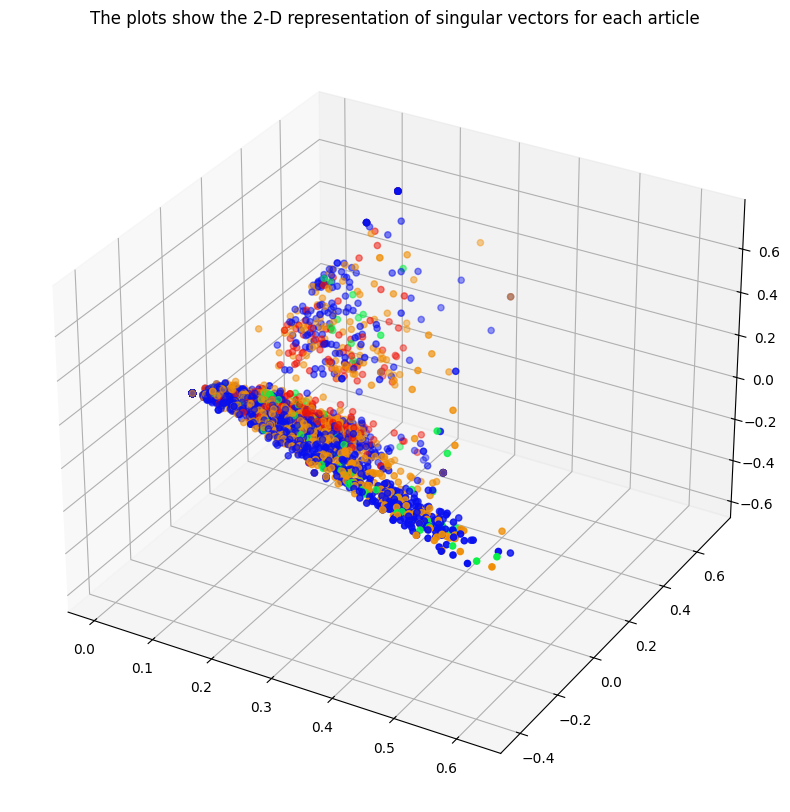

In [44]:
mapping = {
    'mixed': '#f08f07', # orange
    'average': '#070ff0', # blue
    'underperforming': '#f01307', # red
    'viral': '#07f045' # green
}
colors = ['orange', 'blue', 'red', 'green']
target = df['label'].map(mapping)

ng_news = TruncatedSVD(n_components=165, random_state=1337)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
X_news_new = ng_news.fit_transform(df_text)
ax.scatter(X_news_new[:, 0], X_news_new[:, 1], X_news_new[:, 2], c=target)
plt.title("The plots show the 2-D representation of "
                "singular vectors for each article")
plt.show()

# Perform Clustering: Hierarchical Clustering Using Ward Linkage

Since the dataset is not too large, we can use hierarchical clustering for better interpretability

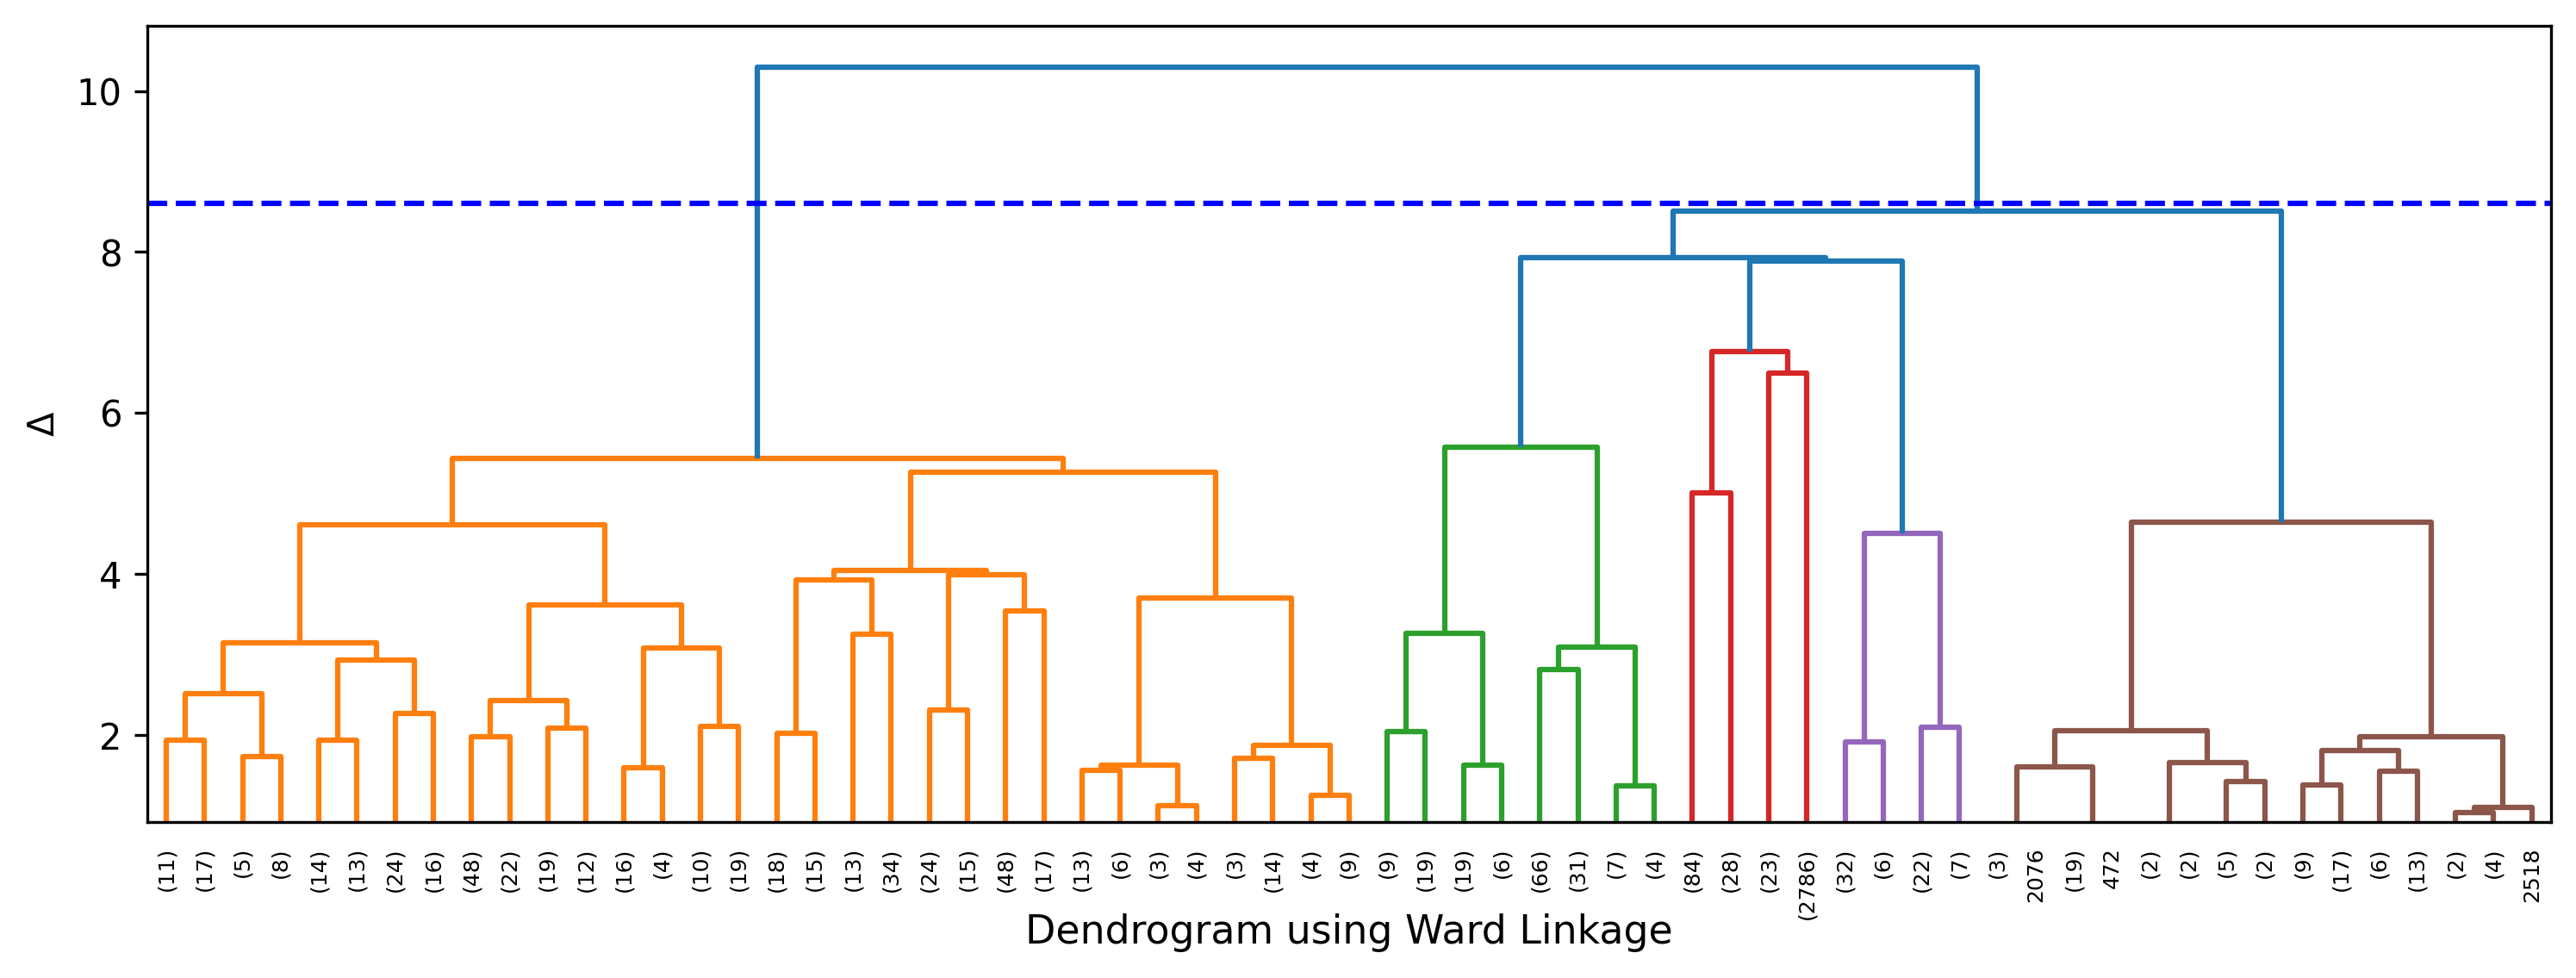

In [45]:
Z = linkage(X_news_new, method="ward", optimal_ordering=True)
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(Z,ax=ax,show_leaf_counts=True, p=5, truncate_mode='level')
plt.axhline(8.6, color='b', linestyle='--')
ax.set_ylabel(r"$\Delta$")
ax.set_ylim(bottom=0.92)
plt.title('Dendrogram using Ward Linkage', fontsize=11, y=-0.18)
plt.show()

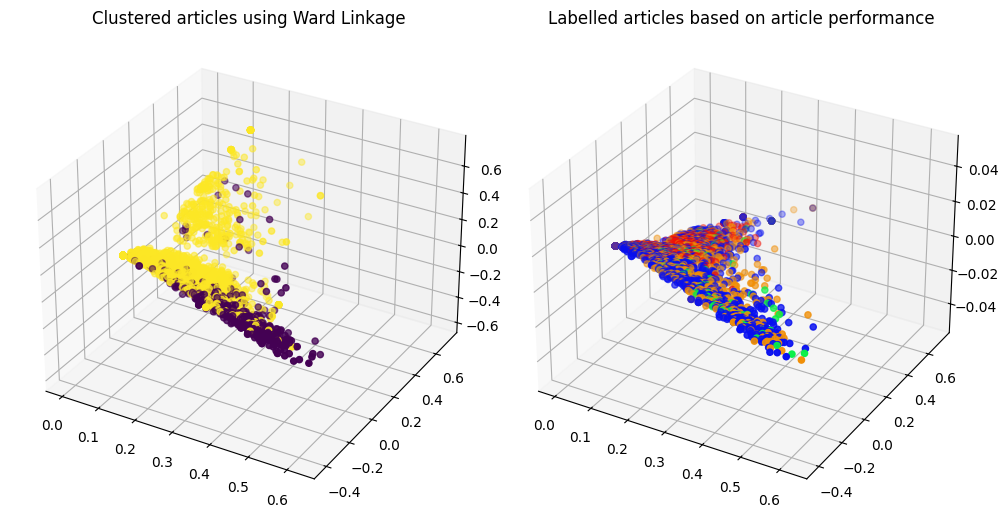

In [46]:
y_predict_news = fcluster(Z, t=8.6, criterion='distance')

fig, axs = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': '3d'},)

axs[0].scatter(X_news_new[:, 0], X_news_new[:, 1], X_news_new[:, 2], c=y_predict_news)
axs[1].scatter(X_news_new[:,0], X_news_new[:,1], c=target)

axs[0].set_title("Clustered articles using Ward Linkage")
axs[1].set_title("Labelled articles based on article performance")
plt.tight_layout()
plt.show()

### Visual Interpretation

What can we say about the 3d plots? Well, it seems like there is a clear mass of clusters after applying clustering. With `t=8.6` (which we obtained from the Dendrogram), we get 2 clusters.

We next need to examine each cluster, and identify the key themes in each.

# Cluster Themes

We now label each cluster by taking the top 25 tokens and determining manually what these clusters are all about.

In [47]:
def get_top_25_tokens(tfidf_matrix, tfidf_vectorizer, y_predict_reviews):
    """
    Return dictionary of top 25 tokens
    """
    # Step 1: Inverse transform the TF-IDF matrix to get the tokens
    tfidf_tokens = tfidf_vectorizer.inverse_transform(tfidf_matrix)
    
    # Step 2: Aggregate TF-IDF scores for each token within each cluster
    cluster_tfidf_scores = defaultdict(lambda: defaultdict(float))
    
    for i, tokens in enumerate(tfidf_tokens):
        cluster_label = y_predict_reviews[i]
        for token in tokens:
            # Sum the TF-IDF score for each token within the cluster
            cluster_tfidf_scores[
                cluster_label][token] += tfidf_matrix[
                    i, tfidf_vectorizer.vocabulary_[token]]
    
    # Step 3: Sort and select the top 25 tokens for clusters 0, 1, and 2
    top_tokens = {}
    for cluster_label in set(y_predict_reviews):
        sorted_tokens = sorted(
            cluster_tfidf_scores[cluster_label].items(), key=lambda x: x[1], reverse=True)
        top_tokens[cluster_label] = sorted_tokens[:25]
    
    return top_tokens
top_tokens = get_top_25_tokens(tfidf_matrix, tfidf_vectorizer, y_predict_news)

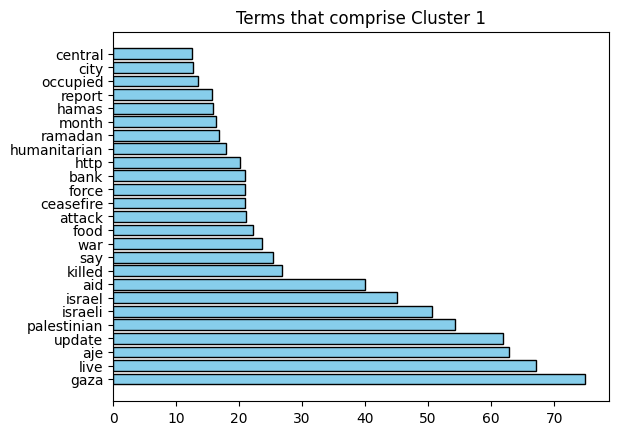

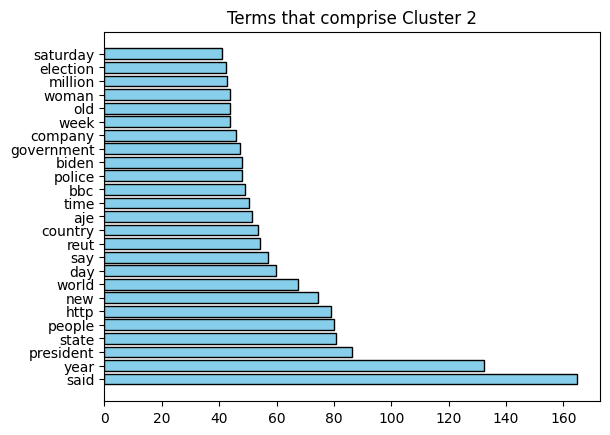

In [48]:
for keys, values in top_tokens.items():
    terms, weights = zip(*values)
    plt.barh(y=terms, width=weights, color='skyblue', edgecolor='black')
    plt.title(f"Terms that comprise Cluster {keys}")
    plt.show()
    

Based on the above, the news articles can be clustered into two main topics: the **War in Gaza** and **General US politics**.

# Does article content dictate social media engagement?

Based on the above clustering, we only get 2 general topics. This means that potentially, the topic of an article does not affect its social media engagement, but rather some external factor like ad spend, copywriting, etc. does.

However, to conduct a thorough investigation, we will attempt to create a machine learning model that takes article features and predicts its social media engagement level (mixed, underperforming, average, viral).

Hence, this is a **classification** problem.

In [49]:
X = tfidf_matrix
y = df['label'].map(
    {
        "underperforming": 0,
        "mixed": 1,
        "average": 2,
        "viral": 4
    }
)
random_state = 888

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [50]:
# run models on default parameters
models = {
    'SVC': SVC(random_state=random_state),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(random_state=random_state),
    'Decision Tree': DecisionTreeClassifier(random_state=random_state),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'Random Forest': RandomForestClassifier(random_state=random_state)
}

results = []
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    runtime = end_time - start_time

    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    y_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    results.append([name, runtime, train_mae, train_r2, test_mae, test_r2])
columns = ['Model', 'Runtime (s)', 'Train MAE',
           'Train R2', 'Test MAE', 'Test R2']
results_df = pd.DataFrame(results, columns=columns)
results_df.sort_values(by=['Test R2', 'Test MAE', 'Runtime (s)'] , ascending=False)

,Model,Runtime (s),Train MAE,Train R2,Test MAE,Test R2
0,SVC,0.484108,0.250418,0.509494,0.518072,0.075226
4,AdaBoost,0.179040,0.535989,0.020239,0.563588,-0.014216
2,MLP,2.226499,0.059592,0.902399,0.566265,-0.030188
5,Random Forest,1.230275,0.058922,0.904068,0.548862,-0.031786
1,KNN,0.001001,0.482089,0.033169,0.621151,-0.185116
3,Decision Tree,0.103023,0.058922,0.904068,0.661312,-0.233032


Based on the initial results, it does not seem promising. Only SVC was able to garner a positive score, and it's extremely close to 0.

# Hyperparameter Tuning

Let's see if we can produce better results with hyperparameter tuning.

In [51]:
def optimize_model(name):
    params_dict = {
        'SVC': {
            'C': [0.25, 0.5, 0.75, 1],
            'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10]    
        },
        'KNN': {
            'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]    
        },
        'MLP': {
            'hidden_layer_sizes': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
            'activation': ['relu', 'tanh', 'logistic', 'identity'],
            'alpha': [0.1, 0.2, 0.3, 0.4, 0.5]
        },
        'Decision Tree': {
            'max_depth': [2, 4, 6, 8, 10]
        },
        'AdaBoost': {
            'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
        },
        'Random Forest': {
            'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
            'max_depth': [2, 4, 6, 8, 10]
        }
    }

    models = {
        'SVC': SVC(random_state=random_state),
        'KNN': KNeighborsClassifier(),
        'MLP': MLPClassifier(random_state=random_state),
        'Decision Tree': DecisionTreeClassifier(random_state=random_state),
        'AdaBoost': AdaBoostClassifier(random_state=random_state),
        'Random Forest': RandomForestClassifier(random_state=random_state)
    }
    parameters = params_dict[name]
    model = models[name]
    model.fit(X_train, y_train)
    scorer = make_scorer(r2_score)
    grid = GridSearchCV(estimator=model, param_grid=parameters, cv=5, n_jobs=10, scoring=scorer, verbose=1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    try:
        best_model = model.set_params(**best_params, random_state=random_state)
    except:
        best_model = model.set_params(**best_params)
    y_pred = best_model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    return best_params, test_r2

best_params_dict = {}
for mname in models.keys():
    best_params, test_r2 = optimize_model(mname)
    best_params_dict[mname] = best_params
    df = pd.DataFrame.from_dict(best_params, orient='index', columns=['Value'])
    print(f"The best parameters for {mname}")
    print(f"Test R2 Score: {test_r2}")
    display(df)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
The best parameters for SVC
Test R2 Score: 0.0752262153193527


,Value
C,1
degree,2


Fitting 5 folds for each of 14 candidates, totalling 70 fits
The best parameters for KNN
Test R2 Score: -0.185115972768636


,Value
n_neighbors,5


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
The best parameters for MLP
Test R2 Score: -0.2697671136806816


,Value
activation,logistic
alpha,0.1
hidden_layer_sizes,200


Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best parameters for Decision Tree
Test R2 Score: -0.23303171290752966


,Value
max_depth,10


Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best parameters for AdaBoost
Test R2 Score: -0.014216499606582111


,Value
n_estimators,50


Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best parameters for Random Forest
Test R2 Score: -0.03178560432417643


,Value
max_depth,10
n_estimators,100


# Conclusion

Based on the test scores, it seems like none of the classifier models are able to detect a meaningful relationship between article content and social media engagement.

Based on the clustering results, we see that the articles revolve around two main topics as well and when compared to the labelled graph, it seems like there is no clear divide between article content and social media engagement.